ExplainTwitch: A Simple Example to Show How to Explain Graph Neural Networks using GNNExplainer over Twitch Dataset

In [3]:
import torch
torch.manual_seed(42)
from IPython.display import clear_output 
torch_version = torch.__version__
print("Torch version: ", torch_version)

Torch version:  2.0.1


In [4]:
from torch_geometric.datasets import Twitch
# Dataset source: https://github.com/benedekrozemberczki/datasets#twitch-social-networks
graph = Twitch(root="./data/Twitch", name="EN")[0]
graph

# Twitch Streamer Dataset:
# - Twitch user-user networks of gamers who stream in a certain language
# - Nodes are the users themselves and the links are mutual friendships between them
# - These social networks were collected in May 2018

Data(x=[7126, 128], edge_index=[2, 77774], y=[7126])

In [5]:
graph.x

# Extracted based on the games played and liked, location and streaming habits
# These are embeddings, which cannot be interpreted directly

tensor([[-0.2367, -0.2307, -0.1605,  ...,  1.3203, -0.2558, -0.1839],
        [-0.2367, -0.2150, -0.1605,  ...,  1.3572, -0.2538, -0.1685],
        [-0.2367, -0.2043, -0.0994,  ..., -0.6348, -0.2558, -0.1839],
        ...,
        [-0.2193, -0.2307, -0.1605,  ..., -0.6348, -0.2558, -0.1839],
        [-0.2367, -0.2307, -0.1605,  ..., -0.6348, -0.2558, -0.1733],
        [ 4.6088, -0.2307, -0.1605,  ...,  1.2370, -0.2558, -0.1839]])

In [6]:
graph.y

# Predict if a streamer uses explicit language

tensor([1, 0, 1,  ..., 0, 0, 1])

<Axes: xlabel='explicit_language'>

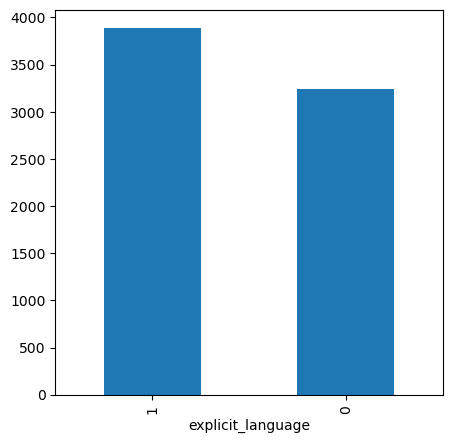

In [7]:
import pandas as pd
from pylab import rcParams
rcParams['figure.figsize'] = 5, 5
df = pd.DataFrame(graph.y.numpy(), columns=["explicit_language"])
df['explicit_language'].value_counts().plot(kind='bar')

In [8]:
from torch.nn import Linear
import torch.nn.functional as F 
from torch_geometric.nn import GATConv
embedding_size = 128

class GNN(torch.nn.Module):
    def __init__(self):
        # Init parent
        super(GNN, self).__init__()

        # GCN layers
        self.initial_conv = GATConv(graph.num_features, embedding_size)
        self.conv1 = GATConv(embedding_size, embedding_size)

        # Output layer
        self.out = Linear(embedding_size, 1)

    def forward(self, x, edge_index):
        emb = F.relu(self.initial_conv(x, edge_index))
        emb = F.relu(self.conv1(emb, edge_index))
        return self.out(emb)

model = GNN()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GNN(
  (initial_conv): GATConv(128, 128, heads=1)
  (conv1): GATConv(128, 128, heads=1)
  (out): Linear(in_features=128, out_features=1, bias=True)
)
Number of parameters:  33665


In [9]:
# Add train and test masks
num_nodes = graph.x.shape[0]
ones = torch.ones(num_nodes)
ones[4000:] = 0
graph.train_mask = ones.bool()
graph.test_mask = ~graph.train_mask.bool()

print("Train nodes: ", sum(graph.train_mask))
print("Test nodes: ", sum(graph.test_mask))

Train nodes:  tensor(4000)
Test nodes:  tensor(3126)


In [10]:
# Use GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = GNN()
model = model.to(device)
graph = graph.to(device)

# Loss function
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)  


def train():
      model.train()
      optimizer.zero_grad() 
      out = model(graph.x, graph.edge_index)  
      preds = out[graph.train_mask]
      targets = torch.unsqueeze(graph.y[graph.train_mask], 1)
      loss = loss_fn(preds.float(), targets.float())  
      loss.backward() 
      optimizer.step()
      return loss

def test():
      model.eval()
      optimizer.zero_grad() 
      out = model(graph.x, graph.edge_index)  
      preds = out[graph.test_mask]
      targets = torch.unsqueeze(graph.y[graph.test_mask], 1)
      loss = loss_fn(preds.float(), targets.float())  
      return loss

for epoch in range(0, 800):
    tr_loss = train()
    if epoch % 100 == 0:
      loss = test()
      print(f'Epoch: {epoch:03d}, Test loss: {loss:.4f} | Train loss: {tr_loss:.4f}')

Epoch: 000, Test loss: 0.6880 | Train loss: 0.6885
Epoch: 100, Test loss: 0.6843 | Train loss: 0.6822
Epoch: 200, Test loss: 0.6824 | Train loss: 0.6774
Epoch: 300, Test loss: 0.6809 | Train loss: 0.6737
Epoch: 400, Test loss: 0.6796 | Train loss: 0.6700
Epoch: 500, Test loss: 0.6785 | Train loss: 0.6658
Epoch: 600, Test loss: 0.6778 | Train loss: 0.6614
Epoch: 700, Test loss: 0.6776 | Train loss: 0.6568


In [11]:
from sklearn.metrics import roc_auc_score

df = pd.DataFrame()
# Model predictions'
out = torch.sigmoid(model(graph.x, graph.edge_index))
df["preds"] = out[graph.test_mask].round().int().cpu().detach().numpy().squeeze()
df["prob"] = out[graph.test_mask].cpu().detach().numpy().squeeze().round(2)

# Groundtruth
df["gt"] = graph.y[graph.test_mask].cpu().detach().numpy().squeeze()

print("Test ROC: ", roc_auc_score(df["gt"], df["preds"]))
df.head(10)

Test ROC:  0.5687391641761471


,preds,prob,gt
0,0,0.49,0
1,1,0.63,1
2,1,0.54,1
3,0,0.45,0
4,1,0.57,1
5,0,0.49,0
6,1,0.52,1
7,0,0.48,0
8,1,0.69,1
9,1,0.57,1


In [20]:
# https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.explain.algorithm.GNNExplainer.html

from torch_geometric.explain import Explainer, GNNExplainer
explainer = Explainer(model=model, 
                      algorithm=GNNExplainer(epochs=200), 
                      explanation_type='model',
                      node_mask_type='attributes',
                      edge_mask_type='object',
                      model_config=dict(
                                        mode='multiclass_classification',
                                        task_level='node',
                                        return_type='log_probs',),
                      )


# Explain node
node_idx = 7
explanation = explainer(graph.x, graph.edge_index, index=node_idx)
print(f'Generated explanations in {explanation.available_explanations}')

path = './results/ExplainTwitch/feature_importance.png'
explanation.visualize_feature_importance(path, top_k=10)
print(f"Feature importance plot has been saved to '{path}'")

path = './results/ExplainTwitch/subgraph.pdf'
explanation.visualize_graph(path)
print(f"Subgraph visualization plot has been saved to '{path}'")

Generated explanations in ['node_mask', 'edge_mask']
Feature importance plot has been saved to './results/ExplainTwitch/feature_importance.png'
Subgraph visualization plot has been saved to './results/ExplainTwitch/subgraph.pdf'
